In [1]:
%reload_ext autoreload
%reload_ext rpy2.ipython

%autoreload 2
%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_style('white')

from nbsupport import tcga as nb_tcga

# Breast cancer dataset

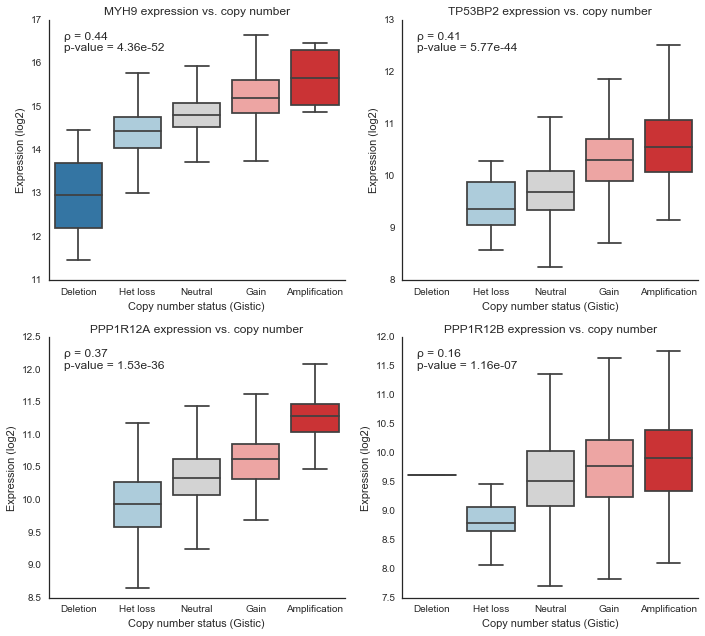

In [2]:
import collections


def _select_tumor_samples(df):
    tumor_cols = [c for c in df.columns
                  if nb_tcga.parse_barcode(c)['sample'].startswith('0')]
    return df[tumor_cols]


def _drop_duplicate_columns(df):
    counts = collections.Counter(df.columns)
    duplicates = [k for k, v in counts.items() if v > 1]
    return df.drop(duplicates, axis=1)


# Read and preprocess datasets.
expr_path = '../data/external/tcga-breast-20160128/rnaseqv2.normalized.txt'
cnv_path = '../data/external/tcga-breast-20160128/all_thresholded.by_genes.txt'

expr_full = (pd.read_csv(expr_path, sep='\t', index_col=0)
               .pipe(_select_tumor_samples)
               .rename(columns=nb_tcga.extract_particpant)
               .pipe(_drop_duplicate_columns)
               .pipe(lambda df: np.log2(df + 1)))

cnv_full = (pd.read_csv(cnv_path, sep='\t', index_col=0)
              .drop(['Locus ID', 'Cytoband'], axis=1)
              .pipe(_select_tumor_samples)
              .rename(columns=nb_tcga.extract_particpant)
              .pipe(_drop_duplicate_columns))

# Subset to common samples.
common_samples = set(expr_full.columns) & set(cnv_full.columns)

expr_full = expr_full[list(common_samples)]
cnv_full = cnv_full[list(common_samples)]

# Plot!
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))
genes = ['MYH9', 'TP53BP2', 'PPP1R12A', 'PPP1R12B']

for gene, ax in zip(genes, axes.flatten()):
    nb_tcga.plot_expr_vs_cn(expr_full, cnv_full, gene_name=gene,
                            ax=ax, show_points=False)
    
fig.tight_layout()

In [5]:
# Draw again for paper.
genes = ['MYH9', 'TP53BP2', 'PPP1R12A', 'PPP1R12B']

for gene in genes:
    with sns.plotting_context('paper', font_scale=0.7):
        fig, ax = plt.subplots(figsize=(2.2, 1.7))
        nb_tcga.plot_expr_vs_cn(
            expr_full, cnv_full, gene_name=gene,
            ax=ax, show_points=False, 
            boxplot_kws={'linewidth': 0.5},
            label_kws={'fontsize': 5})
        
        ax.set_xlabel('')
        ax.set_title('')
        ax.set_xticklabels(['Deletion', 'Het loss', 'Neutral',
                            'Gain', 'Ampl.'])
        
    fig.savefig('../reports/figures/fig_4_{}.pdf'
                .format(gene.lower()), bbox_inches='tight')
    plt.close(fig)

# ILC dataset

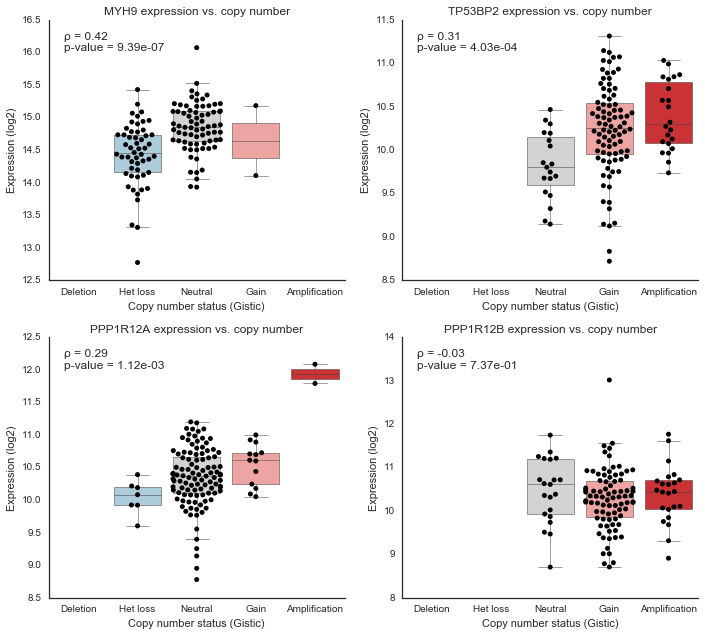

In [6]:
# Read and preprocess datasets.
expr_path = '../data/external/tcga-ilc-2015/ILC_rnaseqv2_RSEM_genes_normalized_data_F2.txt'
cnv_path = '../data/external/tcga-ilc-2015/ILC_gistic_all_thresholded_by_genes_F2.txt'

expr_ilc = (pd.read_csv(expr_path, sep='\t', index_col=0)
              .drop(['Unnamed: 128'], axis=1)
              .pipe(lambda df: np.log2(df + 1)))

cnv_ilc = (pd.read_csv(cnv_path, sep='\t', index_col=0)
             .drop(['Locus ID', 'Cytoband', 'Unnamed: 130'], axis=1))

# Plot!
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 9))
genes = ['MYH9', 'TP53BP2', 'PPP1R12A', 'PPP1R12B']

for gene, ax in zip(genes, axes.flatten()):
    nb_tcga.plot_expr_vs_cn(
        expr_ilc, cnv_ilc, gene_name=gene,
        ax=ax, show_points=True,
        boxplot_kws={'linewidth': 0.5})
    
fig.tight_layout()